# Python实现自适应线性神经元

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
class AdalineGD(object):
    def __init__(self, eta=0.01, n_iter=50):
        self.eta = eta
        self.n_iter = n_iter
        
    def fit(self, X, y):
        self.w_ = np.zeros(1 + X.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_[1:] += self.eta * X.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            cost = (errors ** 2).sum() / 2.0
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        """ Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, X):
        """ Compute linear activation"""
        return self.net_input(X)
    
    def predict(self, X):
        """ Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

导入数据:

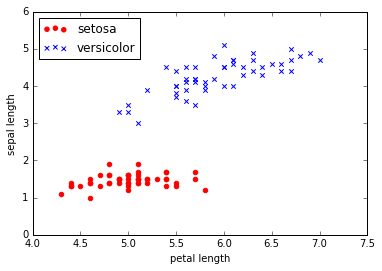

In [26]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', header=None)  
y = df.iloc[0:100, 4].values
y = np.where(y == 'Iris-setosa', -1, 1)  
X = df.iloc[0:100, [0,2]].values

plt.scatter(X[:50, 0], X[:50, 1], color='red', marker='o', label='setosa')
plt.scatter(X[50:, 0], X[50:, 1], color='blue', marker='x', label='versicolor')
plt.xlabel('petal length')
plt.ylabel('sepal length')
plt.legend(loc='upper left')
plt.show()

在将Adaline应用到实际问题中时，通常需要先确定一个好的学习率这样才能保证算法真正收敛。我们来做一个试验，设置两个不同的eta值:eta=0.01, eta=0.0001。然后将每一轮的损失函数值画出来，窥探Adaline是如何学习的.

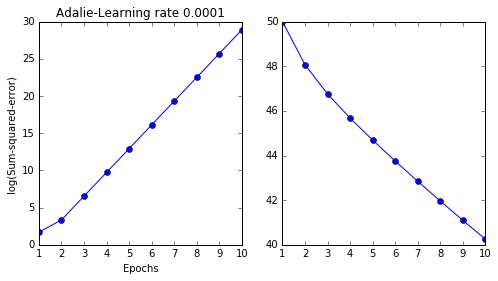

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
ada1 = AdalineGD(n_iter=10, eta=0.01).fit(X,y)
ax[0].plot(range(1, len(ada1.cost_) + 1),
          np.log10(ada1.cost_), marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adalie-Learning rate 0.01')

ada2 = AdalineGD(n_iter=10, eta=0.0001).fit(X,y)
ax[1].plot(range(1, len(ada2.cost_) + 1),
          ada2.cost_, marker='o')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('log(Sum-squared-error)')
ax[0].set_title('Adalie-Learning rate 0.0001')
plt.show()

分析上面两幅图各自的问题，左图根本不是在最小化损失函数，反而在每一轮迭代过程中，损失函数值不断在增大！这说明取值过大的学习率不但对算法毫无益处反而危害大大滴。右图虽然能够在每一轮迭代过程中一直在减小损失函数的值，但是减小的幅度太小了，估计至少上百轮迭代才能收敛，而这个时间我们是耗不起的，所以学习率值过小就会导致算法收敛的时间巨长，使得算法根本不能应用于实际问题。

许多机器学习算法都要求先对特征进行某种缩放操作，比如标准化(standardization)和归一化(normalization)。而缩放后的特征通常更有助于算法收敛，实际上，对特征缩放后在运用梯度下降算法往往会有更好的学习效果。

In [28]:
X_std = np.copy(X)
X_std[:,0] = (X[:,0] - X[:,0].mean()) / X[:,0].std()
X_std[:,1] = (X[:,1] - X[:,1].mean()) / X[:,1].std()

标准化后，我们用Adaline算法来训练模型，看看如何收敛的(学习率为0.01)： 

In [29]:
ada = AdalineGD(n_iter=15, eta=0.01)
ada.fit(X_std, y)

我们将算法学习情况可视化出来:

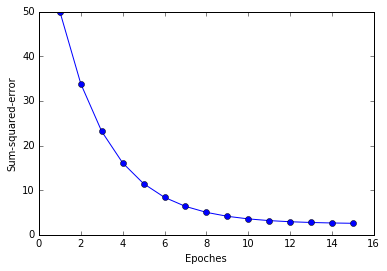

In [30]:
plt.plot(range(1, len(ada.cost_) + 1), ada.cost_, marker='o')
plt.xlabel('Epoches')
plt.ylabel('Sum-squared-error')
plt.show()

Wow 标准化后的数据再使用梯度下降Adaline算法竟然收敛了！

随机梯度下降法求解Adaline

In [31]:
from numpy.random import seed

class AdalineSGD(object):
    def __init__(self, eta=0.01, n_iter=10, shuffle=True, random_state=None):
        self.eta = eta
        self.n_iter = n_iter
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state:
            seed(random_state)

    def fit(self, X, y):
        """Fit training data."""
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            cost = []
            for xi, target in zip(X, y):
                cost.append(self._update_weights(xi, target))
            avg_cost = sum(cost)/len(y)
            self.cost_.append(avg_cost)
        return self

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights."""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, target in zip(X, y):
                self._update_weights(xi, target)
        else:
            self._update_weights(X, y)
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]

    def _initialize_weights(self, m):
        """Initialize weights to zeros"""
        self.w_ = np.zeros(1 + m)
        self.w_initialized = True

    def _update_weights(self, xi, target):
        """Apply Adaline learning rule to update the weights"""
        output = self.net_input(xi)
        error = (target - output)
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        cost = 0.5 * error ** 2
        return cost

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

我们使用fit方法训练AdalineSGD模型

In [32]:
ada = AdalineSGD(n_iter=15, eta=0.01, random_state=1)
ada.fit(X_std, y)

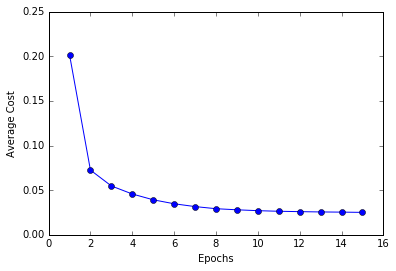

In [33]:
plt.plot(range(1, len(ada.cost_) + 1),  ada.cost_, marker='o')
plt.xlabel('Epochs')
plt.ylabel('Average Cost')
plt.show()

我们可以发现，平均损失(average cost)下降的非常快，在第15次迭代后决策界和使用梯度下降的Adaline决策界非常相似。